In [3]:
import nutpie
import pathlib
import arviz
import subprocess
import dask
import dask.distributed
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import posteriordb
import json
import cmdstanpy
import time
import fastprogress
import pandas as pd
import xarray as xr
import holoviews as hv

In [4]:
def find_discrete(tr):
    is_discrete = ((tr.posterior == tr.posterior.round()).sum() > 100).to_array()
    if all(is_discrete):
        return []
    return list(is_discrete.where(is_discrete, np.nan).dropna("variable")["variable"].values)

In [45]:
storage = f"/mnt/harddrives/data_labs/covadapt-paper/2022-11-07-model-zoo_1000_grad_init/"

In [46]:
tr = arviz.from_netcdf(f"{storage}/rats_data-rats_model_nutpie.nc").load()

In [7]:
def summarize_traces(db, storage):
    
    posterior_grad_evals_nutpie = []
    posterior_grad_evals_stan = []

    grad_evals_nutpie = []
    grad_evals_stan = []

    divs_stan = []
    divs_nutpie = []

    ess_mins_nutpie = []
    ess_mins_stan = []

    times_nutpie = []
    times_stan = []
    
    model_names = []

    for i, name in enumerate(db.posterior_names()):
        #if i > 80:
        #    break
        try:
            tr_nutpie = arviz.from_netcdf(f"{storage}/{name}_nutpie.nc").isel(draw=slice(None, 1000))
            tr_stan = arviz.from_netcdf(f"{storage}/{name}_stan.nc").isel(draw=slice(None, 1000))
        except FileNotFoundError:
            continue
        divs_stan.append(tr_stan.sample_stats.diverging.sum())
        divs_nutpie.append(tr_nutpie.sample_stats.diverging.sum())
        posterior_grad_evals_nutpie.append(tr_nutpie.sample_stats.n_steps.sum())
        posterior_grad_evals_stan.append(tr_stan.sample_stats.n_steps.sum())
        grad_evals_nutpie.append(posterior_grad_evals_nutpie[-1] + tr_nutpie.warmup_sample_stats.n_steps.sum())
        grad_evals_stan.append(posterior_grad_evals_stan[-1] + tr_stan.warmup_sample_stats.n_steps.sum())

        times_nutpie.append(tr_nutpie.posterior.attrs["sampling_time"])
        times_stan.append(tr_stan.posterior.attrs["sampling_time"])

        discrete = find_discrete(tr_nutpie)

        ess_nutpie = xr.open_dataset(f"{storage}/{name}_nutpie_ess.nc")
        ess_stan = xr.open_dataset(f"{storage}/{name}_stan_ess.nc")
        ess_mins_nutpie.append(ess_nutpie.drop_vars(discrete).min().to_array().min().values)
        ess_mins_stan.append(ess_stan.drop_vars(discrete).min().to_array().min().values)
        
        model_names.append(name)
        
    divs_stan = np.array(divs_stan)
    divs_nutpie = np.array(divs_nutpie)
    grad_evals_nutpie = np.array(grad_evals_nutpie)
    grad_evals_stan = np.array(grad_evals_stan)
    posterior_grad_evals_nutpie = np.array(posterior_grad_evals_nutpie)
    posterior_grad_evals_stan = np.array(posterior_grad_evals_stan)
    ess_mins_nutpie = np.array(ess_mins_nutpie)
    ess_mins_stan = np.array(ess_mins_stan)
    times_nutpie = np.array(times_nutpie)
    times_stan = np.array(times_stan)
    
    ds = xr.Dataset(
        {
            "divergences": (("sampler", "model"), [divs_stan, divs_nutpie]),
            "total_grad_evals": (("sampler", "model"), [grad_evals_stan, grad_evals_nutpie]),
            "posterior_grad_evals": (("sampler", "model"), [posterior_grad_evals_stan, posterior_grad_evals_nutpie]),
            "ess": (("sampler", "model"), [ess_mins_stan, ess_mins_nutpie]),
            "time": (("sampler", "model"), [times_stan, times_nutpie]),
        },
        coords={
            "sampler": pd.Index(["stan", "nutpie"]),
            "model": pd.Index(model_names),
        },
    )
    return ds

In [8]:
db = posteriordb.PosteriorDatabase("../../posteriordb/posterior_database/")
summaries = []
tune = [200, 300, 1000]
for n_tune in tune:
    storage = f"/mnt/harddrives/data_labs/covadapt-paper/2022-11-07-model-zoo_{n_tune}_grad_init/"
    summaries.append(summarize_traces(db, storage))
ds = xr.concat(summaries, pd.Index(tune, name="num_tune"))

In [9]:
ds_all = ds

In [10]:
good = ((ds_all.ess > 500) & (ds_all.divergences < 5)).any(["sampler", "num_tune"])

In [11]:
ds = ds_all.sel(model=good)

In [12]:
ds["ess_per_posterior_grad"] = ds.ess / ds.posterior_grad_evals
ds["ess_per_grad"] = ds.ess / ds.total_grad_evals

In [13]:
len(ds.model)

109

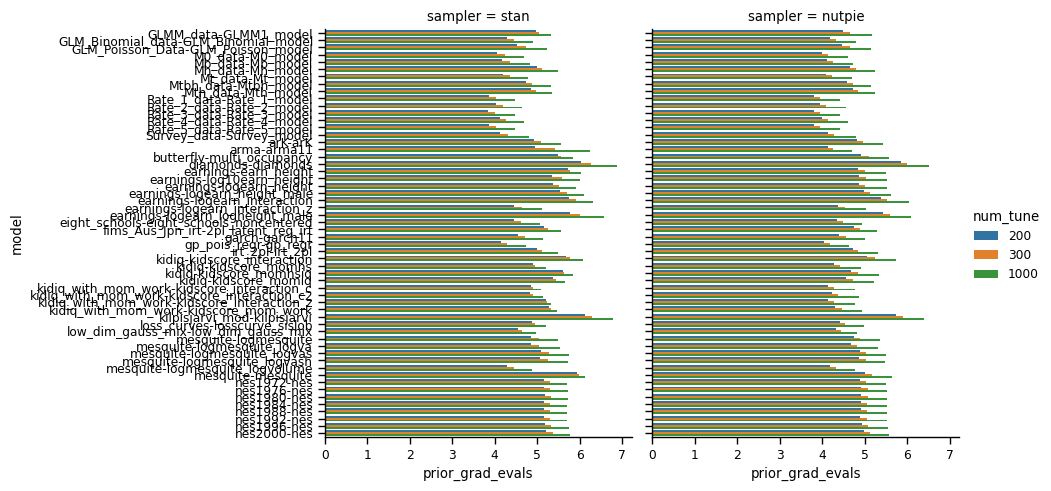

In [88]:
sns.catplot(
    np.log10(ds.total_grad_evals - ds.posterior_grad_evals).to_dataframe("prior_grad_evals").reset_index(),
    x="prior_grad_evals",
    y="model",
    hue="num_tune",
    kind="bar",
    col="sampler"
)

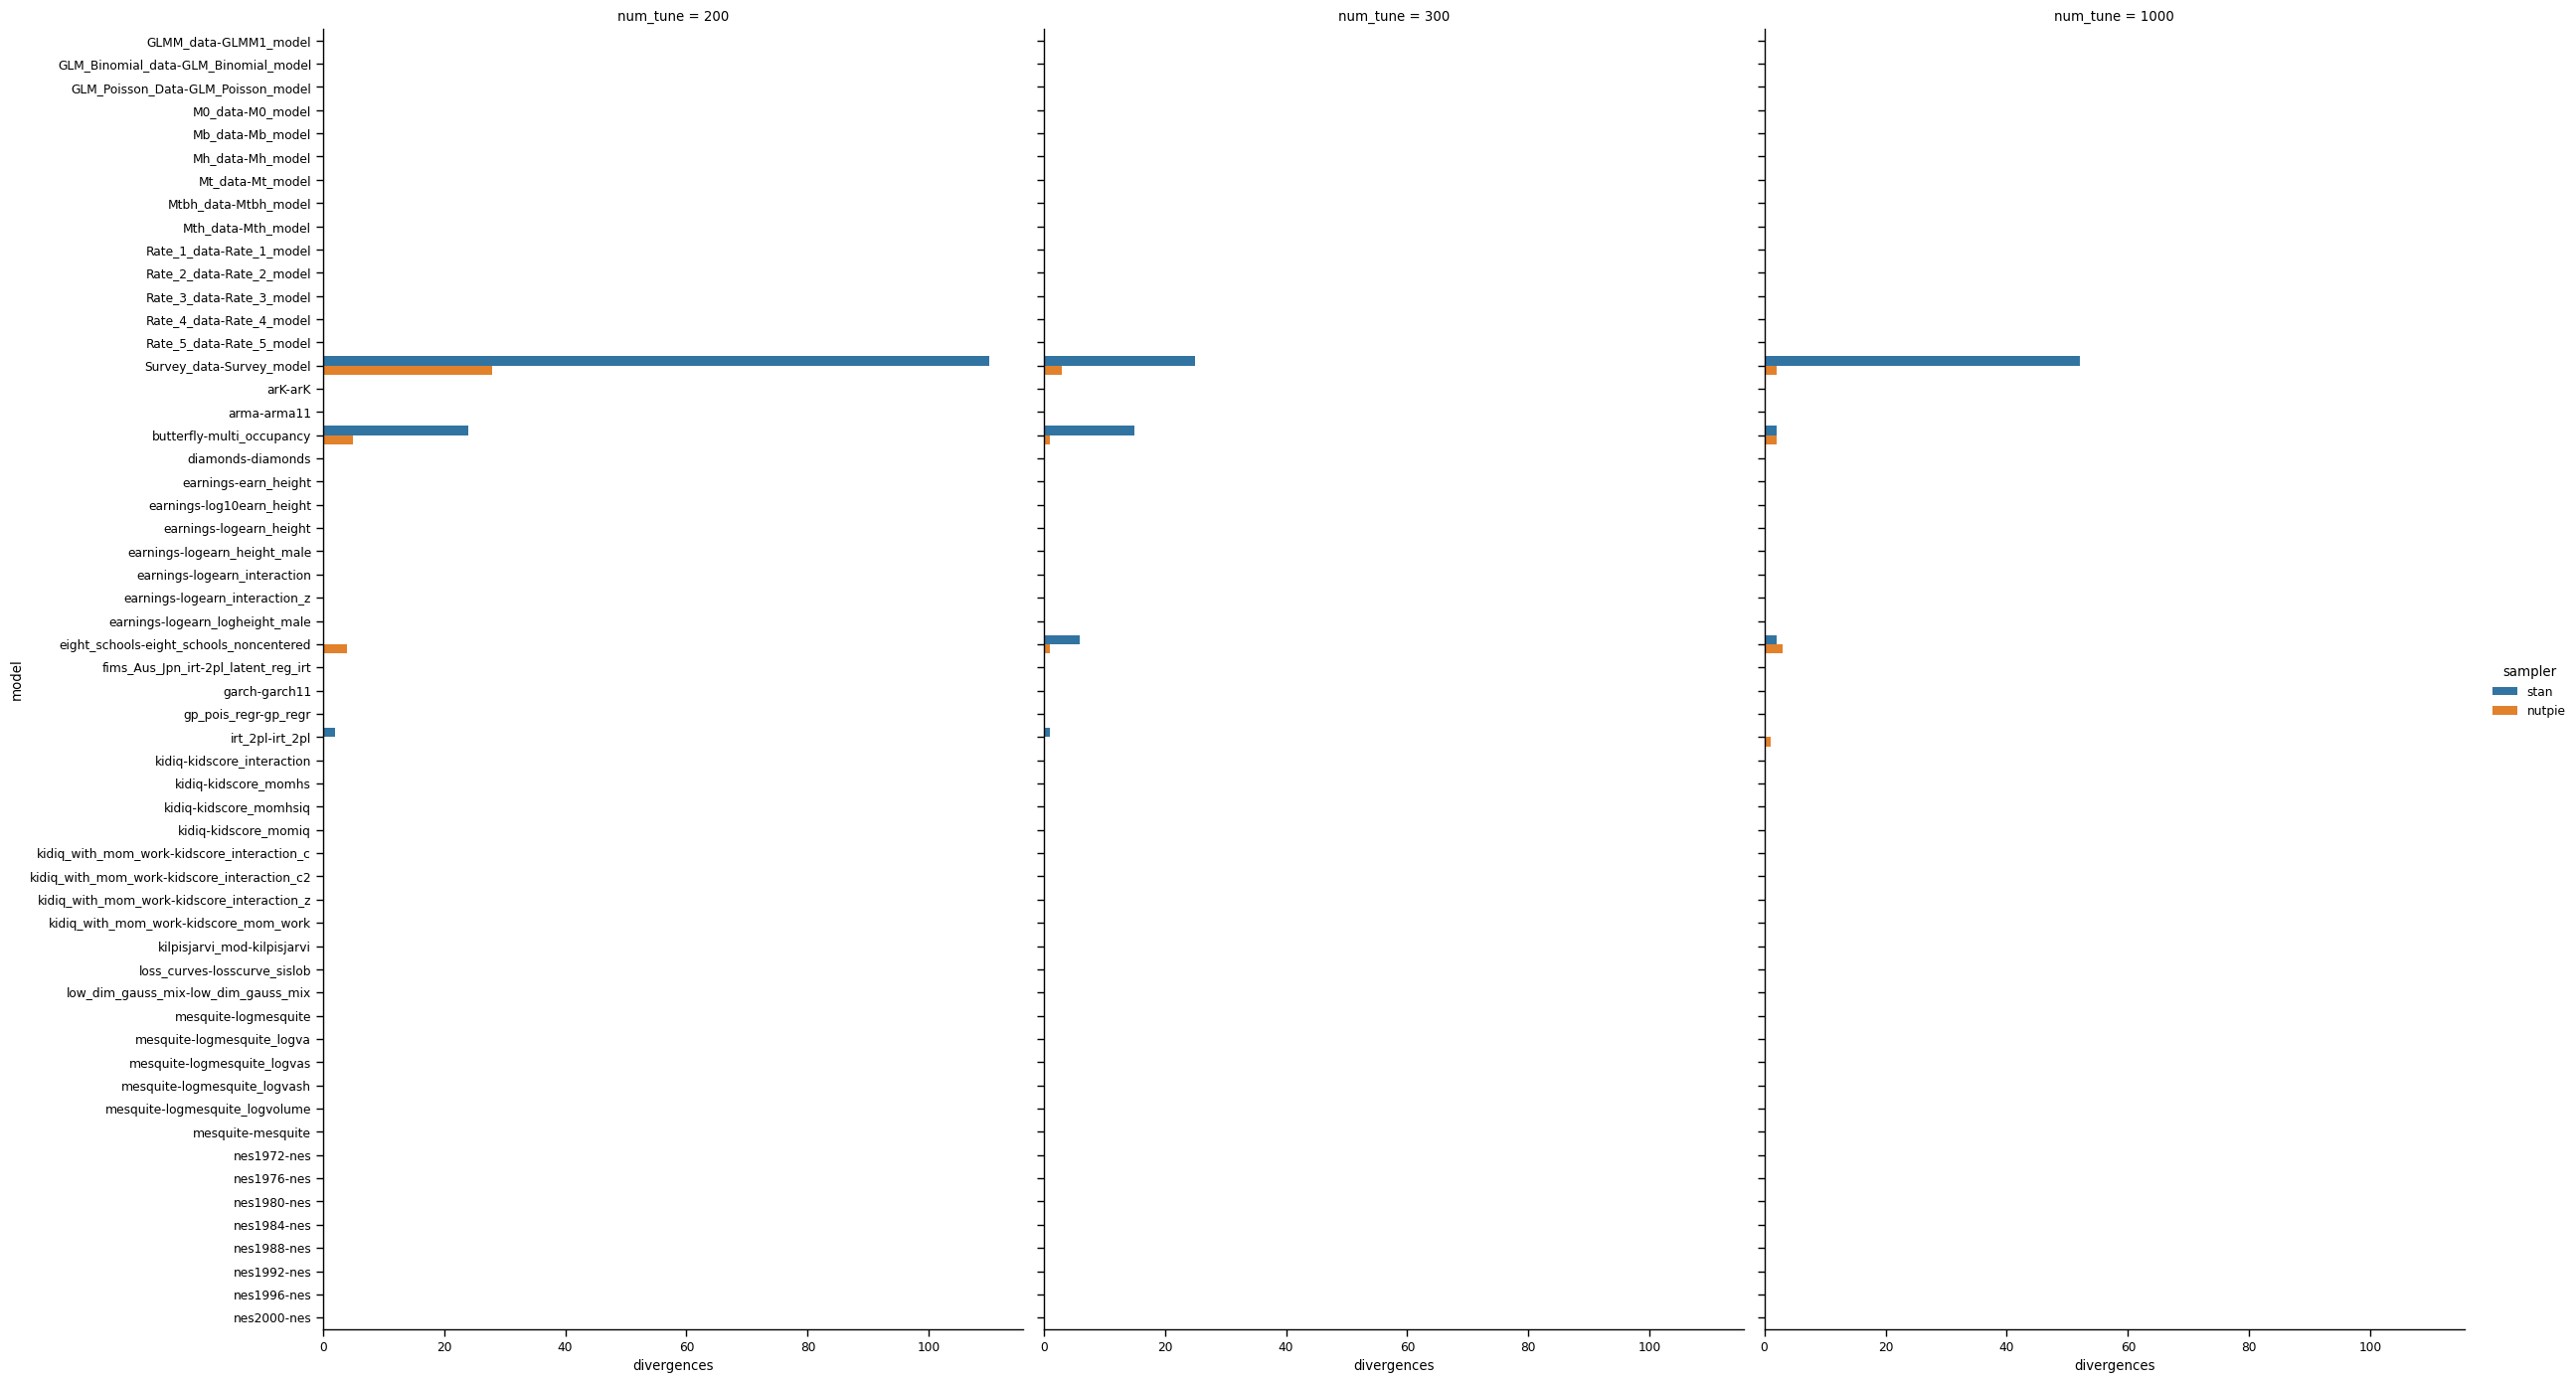

In [89]:
sns.catplot(ds.divergences.to_dataframe().reset_index(), x="divergences", y="model", hue="sampler", col="num_tune", orient="h", kind="bar", height=14, aspect=0.6)

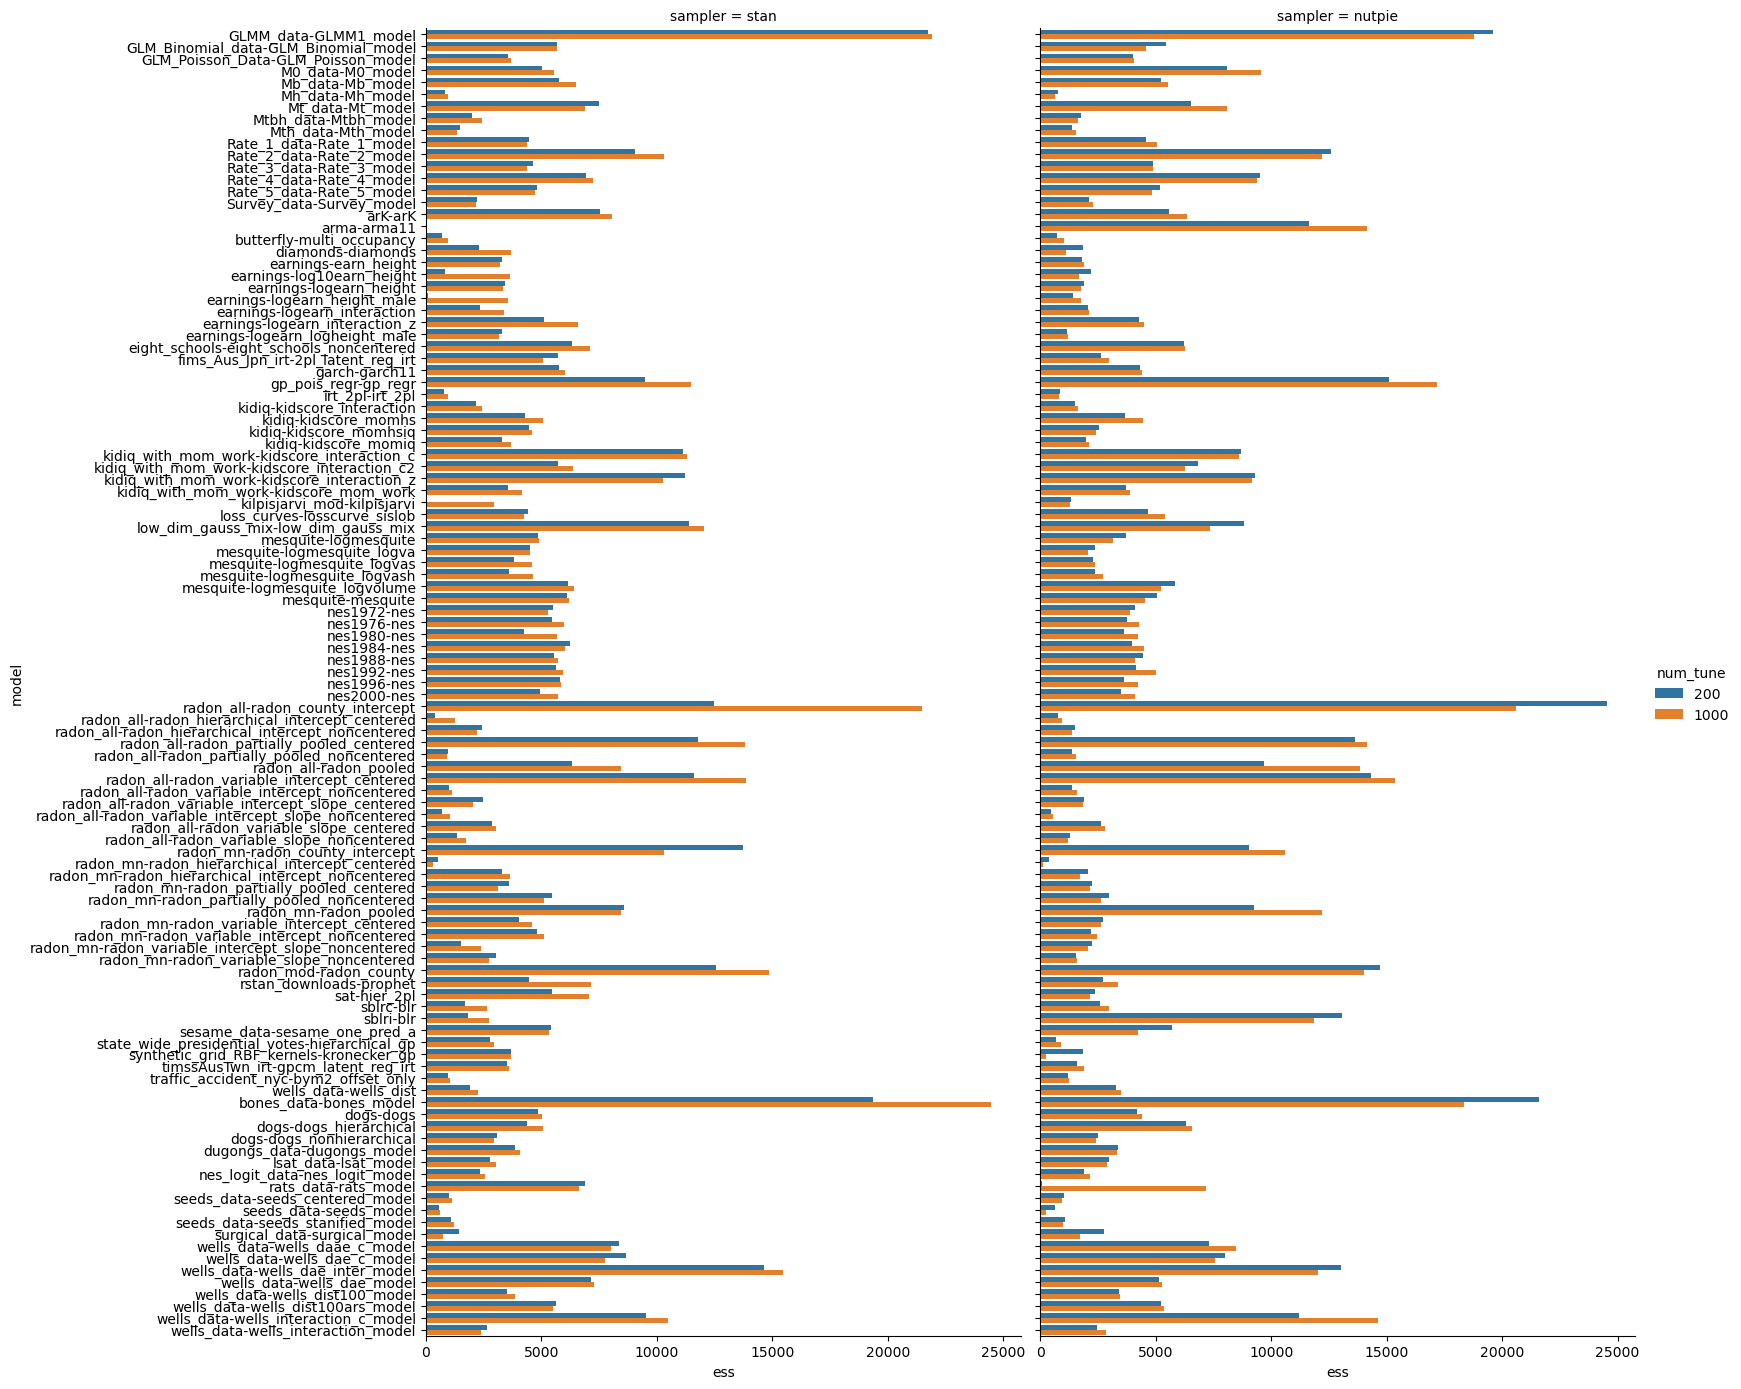

In [12]:
sns.catplot(ds.ess.to_dataframe().reset_index(), x="ess", y="model", col="sampler", hue="num_tune", orient="h", kind="bar", height=14, aspect=0.6)

In [ ]:
rats_data-rats_model

In [90]:
ds["ess_per_time"] = ds.ess / ds.time

In [91]:
ds["time_per_grad"] = ds.time / ds.total_grad_evals

In [92]:
sns.set_context("paper")

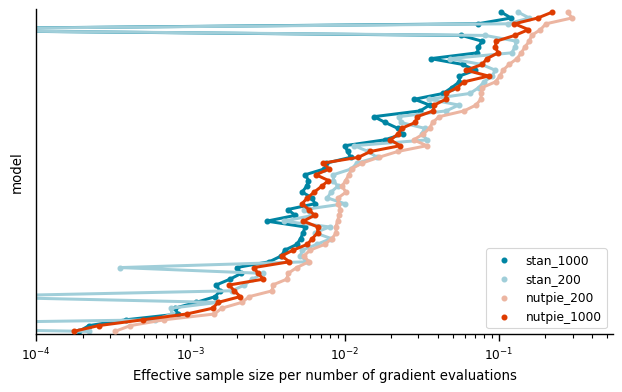

In [93]:
#x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
ds_ = ds.ess_per_grad.stack(variant=["sampler", "num_tune"])
x = ds_.drop_vars({'num_tune', 'variant', 'sampler'}).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(ds_.sampler.values, ds_.num_tune.values)])
sort = x.max("variant")
g = sns.catplot(
    #ds.time.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    #ylabel=False,
    x="ess_per_grad",
    y="model",
    hue="variant",
    #hue="num_tune",
    #style="sampler",
    #col="sampler",
    orient="h",
    kind="point",
    height=4,
    aspect=2.3,
    #scale="log",
    #palette=sns.color_palette("coolwarm", n_colors=4, desat=1),
    hue_order=["stan_1000", "stan_200", "nutpie_200", "nutpie_1000"],
    palette=sns.diverging_palette(220, 20, n=4, s=120),
    legend=False,
    markers='.',
)
g.set(xscale="log")
#g.despine()
ax = g.axes[0, 0]
ax.set_yticklabels([]);
ax.set_xlim(1e-4, None)
ax.legend(loc="lower right")
ax.set_xlabel("Effective sample size per number of gradient evaluations")
ax.set_yticks([]);
g.figure.savefig("../figures/ess_per_grad.pdf", bbox_inches="tight", pad_inches=0.1)

In [17]:
import matplotlib

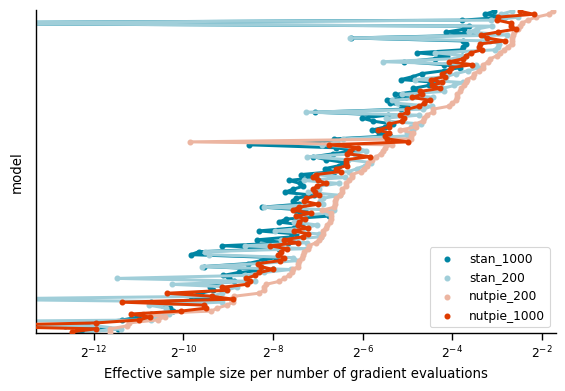

In [57]:
#x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
ds_ = ds.ess_per_grad.stack(variant=["sampler", "num_tune"])
x = ds_.drop_vars({'num_tune', 'variant', 'sampler'}).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(ds_.sampler.values, ds_.num_tune.values)])
sort = x.max("variant")
g = sns.catplot(
    #ds.time.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    #ylabel=False,
    x="ess_per_grad",
    y="model",
    hue="variant",
    #hue="num_tune",
    #style="sampler",
    #col="sampler",
    orient="h",
    kind="point",
    height=4,
    aspect=2.3,
    #scale="log",
    #palette=sns.color_palette("coolwarm", n_colors=4, desat=1),
    hue_order=["stan_1000", "stan_200", "nutpie_200", "nutpie_1000"],
    palette=sns.diverging_palette(220, 20, n=4, s=120),
    legend=False,
    markers='.',
)
#g.set(xscale="log")
#g.despine()
ax = g.axes[0, 0]
ax.set_yticklabels([]);
ax.set_xlim(1e-4, None)
ax.set_xscale('log', base=2)
ax.legend(loc="lower right")
ax.set_xlabel("Effective sample size per number of gradient evaluations")
ax.set_yticks([]);
g.figure.savefig("../figures/ess_per_grad.pdf", bbox_inches="tight", pad_inches=0.1)

/home/adr/mambaforge/envs/pymc-dev/lib/python3.10/site-packages/xarray/core/common.py:609: FutureWarning: Updating MultiIndexed coordinate 'variant' would corrupt indices for other variables: ['sampler', 'num_tune']. This will raise an error in the future. Use `.drop_vars({'num_tune', 'variant', 'sampler'})` before assigning new coordinate values.
  data.coords.update(results)


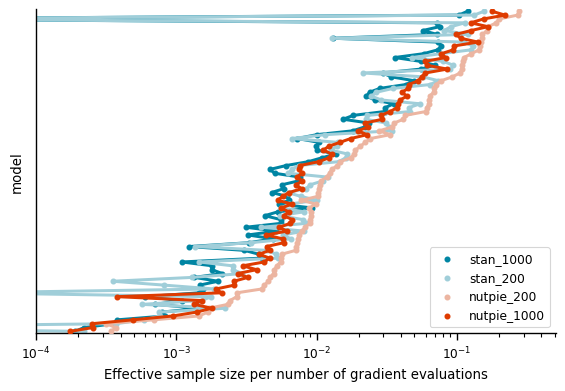

In [157]:
x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
sort = x.max("variant")
g = sns.catplot(
    #ds.time.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    #ylabel=False,
    x="ess_per_grad",
    y="model",
    hue="variant",
    #hue="num_tune",
    #style="sampler",
    #col="sampler",
    orient="h",
    kind="point",
    height=4,
    aspect=2.3,
    #scale="log",
    #palette=sns.color_palette("coolwarm", n_colors=4, desat=1),
    hue_order=["stan_1000", "stan_200", "nutpie_200", "nutpie_1000"],
    palette=sns.diverging_palette(220, 20, n=4, s=120),
    legend=False,
    markers='.',
)
g.set(xscale="log")
#g.despine()
ax = g.axes[0, 0]
ax.set_yticklabels([]);
ax.set_xlim(1e-4, None)
ax.legend(loc="lower right")
ax.set_xlabel("Effective sample size per number of gradient evaluations")
ax.set_yticks([]);
g.figure.savefig("../figures/ess_per_grad.pdf", bbox_inches="tight", pad_inches=0.1)

In [33]:
palette = sns.diverging_palette(220, 20, n=6, s=120)

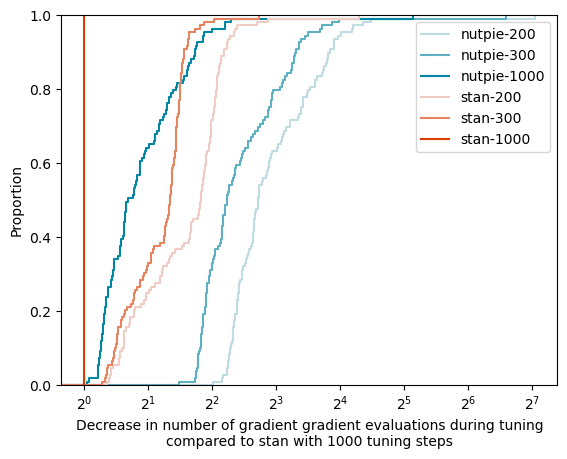

In [76]:
prior_grads = ds.total_grad_evals - ds.posterior_grad_evals
a1 = prior_grads.sel(num_tune=200, sampler="nutpie")
b1 = prior_grads.sel(num_tune=200, sampler="stan")
a2 = prior_grads.sel(num_tune=300, sampler="nutpie")
b2 = prior_grads.sel(num_tune=300, sampler="stan")
a3 = prior_grads.sel(num_tune=1000, sampler="nutpie")
b = prior_grads.sel(num_tune=1000, sampler="stan")

sns.ecdfplot(b / a1, color=palette[2], label="nutpie-200")
sns.ecdfplot(b / a2, color=palette[1], label="nutpie-300")
sns.ecdfplot(b / a3, color=palette[0], label="nutpie-1000")

sns.ecdfplot(b / b1, color=palette[3], label="stan-200")
sns.ecdfplot(b / b2, color=palette[4], label="stan-300")
#plt.axvline(1, color=palette[5])

#plt.xlim(0.5, 2)
plt.legend()
plt.axvline(1, color=palette[5], label="stan-1000")

plt.gca().set_xscale("log", base=2)

plt.xlabel("Decrease in number of gradient gradient evaluations during tuning\ncompared to stan with 1000 tuning steps")

plt.legend()

In [37]:
palette[0]

(0.0, 0.5200780967709547, 0.6384051503188303)

Text(0, 0.5, 'Proportion of models')

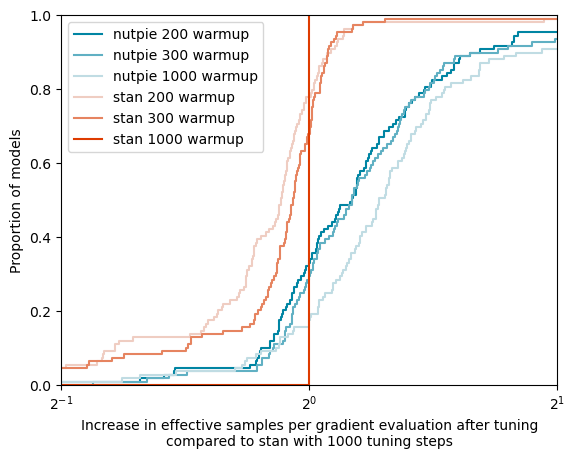

In [68]:
a1 = ds.ess_per_posterior_grad.sel(num_tune=200, sampler="nutpie")
b1 = ds.ess_per_posterior_grad.sel(num_tune=200, sampler="stan")
a2 = ds.ess_per_posterior_grad.sel(num_tune=300, sampler="nutpie")
b2 = ds.ess_per_posterior_grad.sel(num_tune=300, sampler="stan")
a3 = ds.ess_per_posterior_grad.sel(num_tune=1000, sampler="nutpie")
b = ds.ess_per_posterior_grad.sel(num_tune=1000, sampler="stan")
sns.ecdfplot(a1 / b, label="nutpie 200 warmup", color=palette[0])
sns.ecdfplot(a2 / b, label="nutpie 300 warmup", color=palette[1])
sns.ecdfplot(a3 / b, label="nutpie 1000 warmup", color=palette[2])
sns.ecdfplot(b1 / b, label="stan 200 warmup", color=palette[3])
sns.ecdfplot(b2 / b, label="stan 300 warmup", color=palette[4])
sns.ecdfplot([1], label="stan 1000 warmup", color=palette[5])

plt.xlim(0.5, 2)
plt.legend()
#plt.axvline(1, color=palette[5])

plt.gca().set_xscale("log", base=2)
plt.legend()

plt.xlabel("Increase in effective samples per gradient evaluation after tuning\ncompared to stan with 1000 tuning steps")
plt.ylabel("Proportion of models")

Text(0, 0.5, 'Proportion of models')

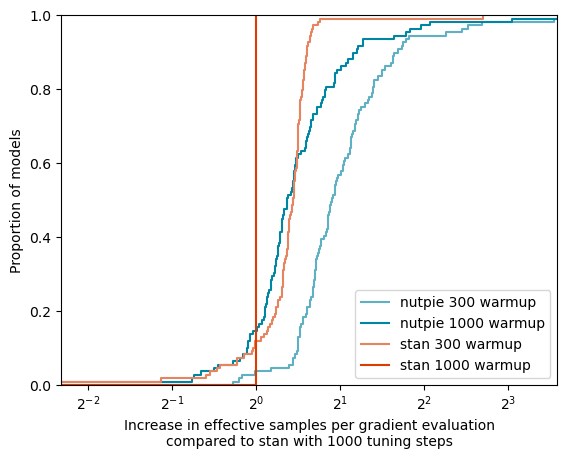

In [70]:
a1 = ds.ess_per_grad.sel(num_tune=200, sampler="nutpie")
b1 = ds.ess_per_grad.sel(num_tune=200, sampler="stan")
a2 = ds.ess_per_grad.sel(num_tune=300, sampler="nutpie")
b2 = ds.ess_per_grad.sel(num_tune=300, sampler="stan")
a3 = ds.ess_per_grad.sel(num_tune=1000, sampler="nutpie")
b = ds.ess_per_grad.sel(num_tune=1000, sampler="stan")
#sns.ecdfplot(a1 / b, label="nutpie-200", color=palette[2])
sns.ecdfplot(a2 / b, label="nutpie 300 warmup", color=palette[1])
sns.ecdfplot(a3 / b, label="nutpie 1000 warmup", color=palette[0])
#sns.ecdfplot(b1 / b, label="stan-200", color=palette[3])
sns.ecdfplot(b2 / b, label="stan 300 warmup", color=palette[4])
sns.ecdfplot([1], label="stan 1000 warmup", color=palette[5])
plt.gca().set_xscale("log", base=2)
plt.xlim(0.2, 12)
plt.legend()
#plt.axvline(1, color=palette[5], label="stan 1000 warmup")
plt.xlabel("Increase in effective samples per gradient evaluation\ncompared to stan with 1000 tuning steps")
plt.ylabel("Proportion of models")

In [74]:
np.exp(np.log(a2 / b).mean())

<xarray.DataArray 'ess_per_grad' ()>
array(2.18526976)

In [26]:
import matplotlib

In [ ]:
matplotlib.scale.LogScale()

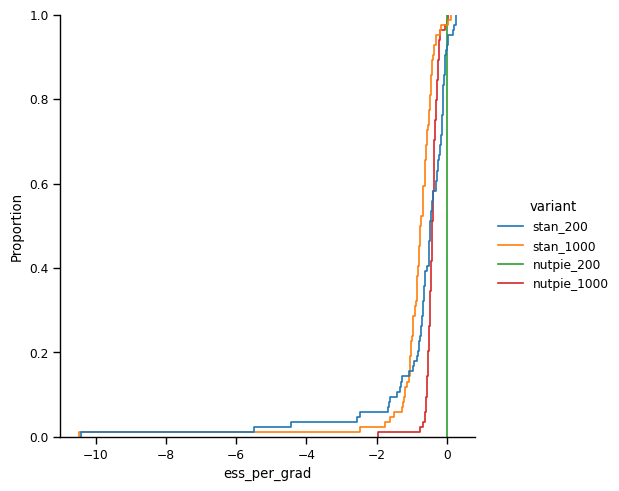

In [159]:
y = np.log(x) - np.log(x).sel(variant="nutpie_200")
sns.displot(y.to_dataframe().reset_index(), hue="variant", x="ess_per_grad", kind="ecdf")

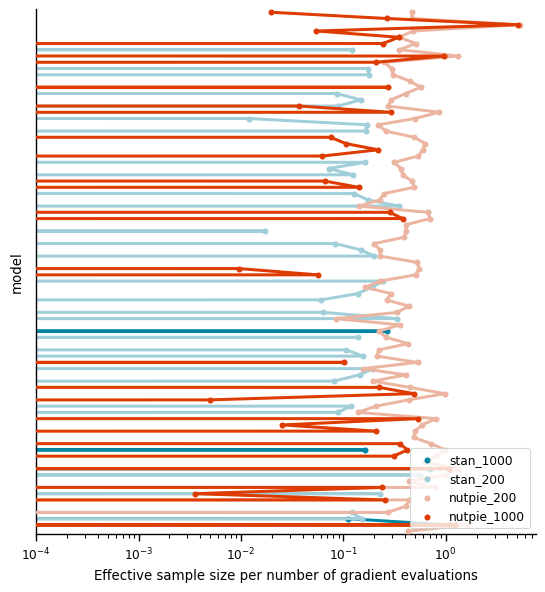

In [160]:
x = np.log(x) - np.log(x).mean("variant")
g = sns.catplot(
    #ds.time.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    #ylabel=False,
    x="ess_per_grad",
    y="model",
    hue="variant",
    #hue="num_tune",
    #style="sampler",
    #col="sampler",
    orient="h",
    kind="point",
    height=6,
    aspect=1.5,
    #scale="log",
    #palette=sns.color_palette("coolwarm", n_colors=4, desat=1),
    hue_order=["stan_1000", "stan_200", "nutpie_200", "nutpie_1000"],
    palette=sns.diverging_palette(220, 20, n=4, s=120),
    legend=False,
    markers='.',
)
g.set(xscale="log")
#g.despine()
ax = g.axes[0, 0]
ax.set_yticklabels([]);
ax.set_xlim(1e-4, None)
ax.legend(loc="lower right")
ax.set_xlabel("Effective sample size per number of gradient evaluations")
ax.set_yticks([]);

In [161]:
ax = g.axes[0, 0]
ax.set_yticklabels([])

[]

In [162]:
g.despine()

In [163]:
p = sns.color_palette("coolwarm")

In [164]:
p[2]

(0.7867207013568628, 0.8448072103686275, 0.9398103849490196)

In [165]:
g.set(xscale="log")

In [52]:
nutpie = ds.ess_per_grad.sel(sampler="nutpie", num_tune=200)
stan = ds.ess_per_grad.sel(sampler="stan", num_tune=200)

<AxesSubplot: ylabel='Count'>

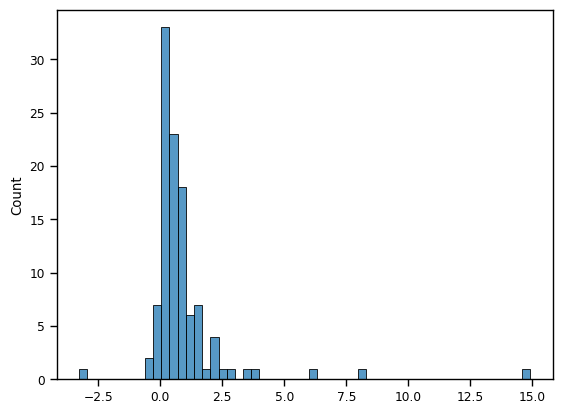

In [53]:
sns.histplot(np.log2((nutpie / stan).values.ravel()))

<AxesSubplot: ylabel='Count'>

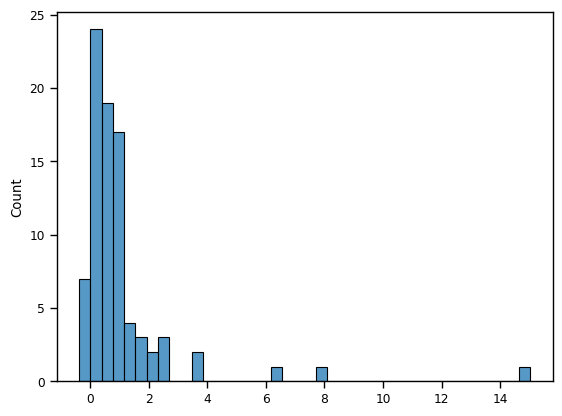

In [171]:
sns.histplot(np.log2((nutpie / stan).values.ravel()))

/home/adr/mambaforge/envs/pymc-dev/lib/python3.10/site-packages/xarray/core/common.py:609: FutureWarning: Updating MultiIndexed coordinate 'variant' would corrupt indices for other variables: ['sampler', 'num_tune']. This will raise an error in the future. Use `.drop_vars({'num_tune', 'variant', 'sampler'})` before assigning new coordinate values.
  data.coords.update(results)


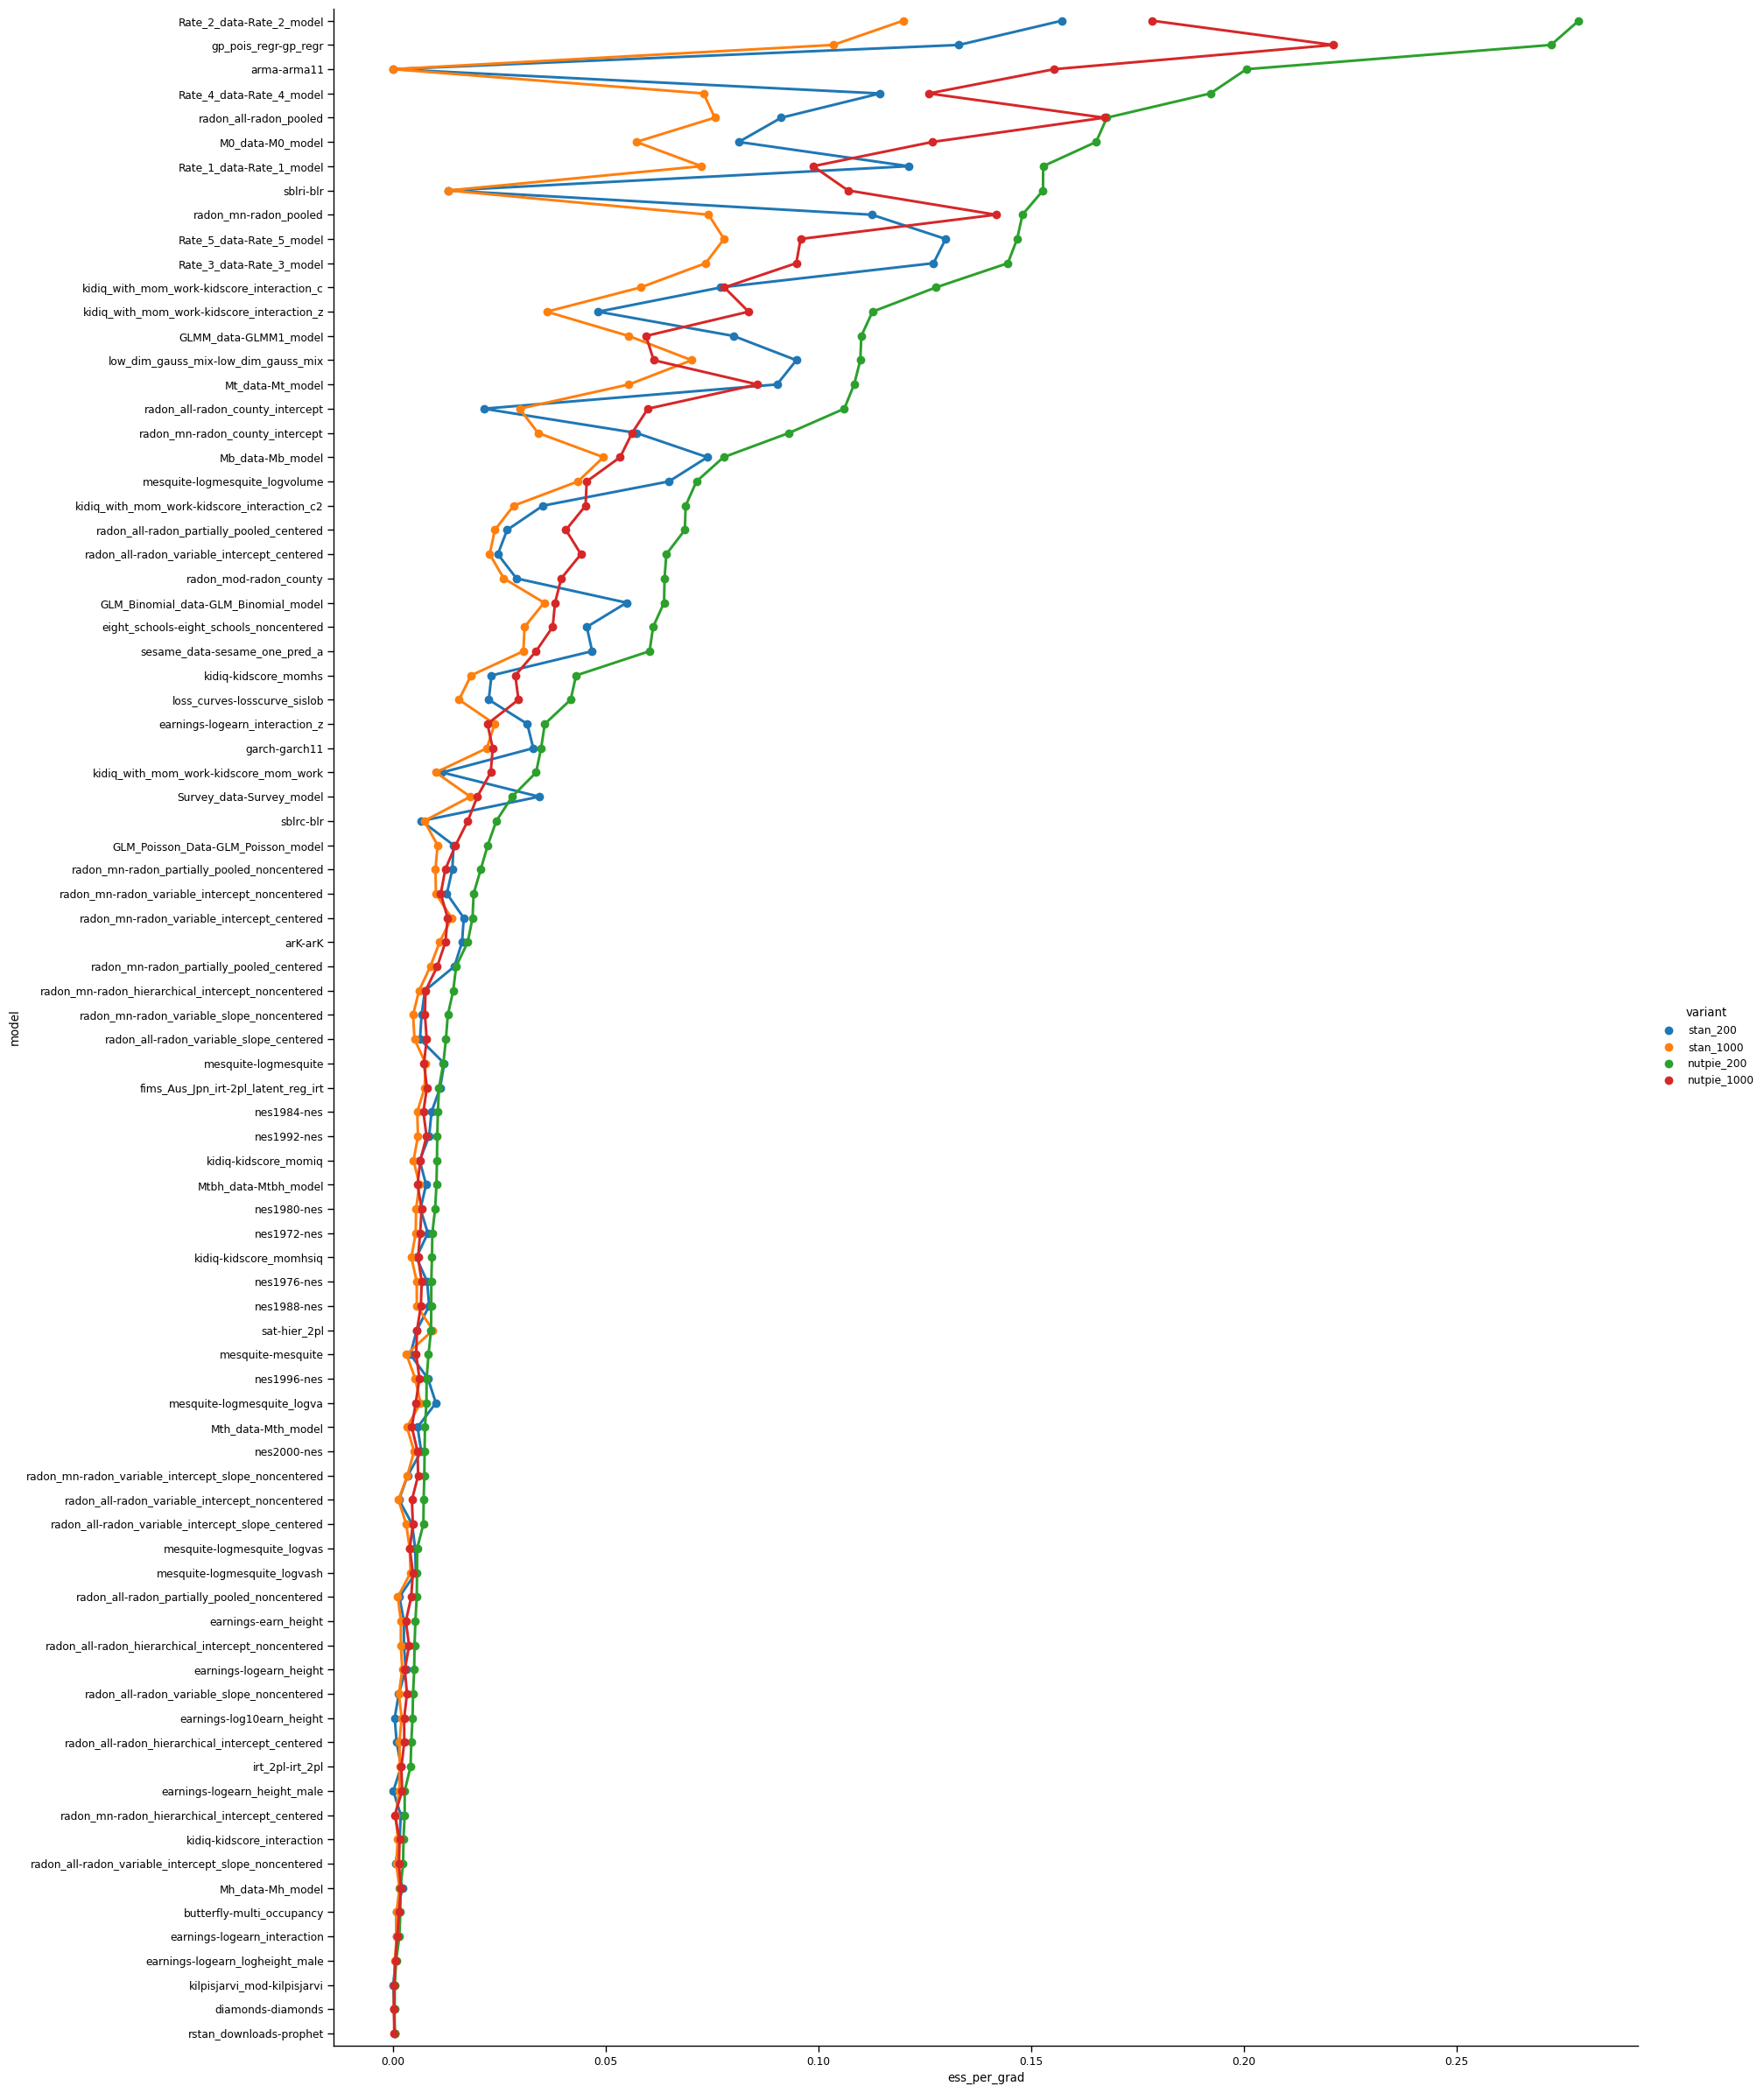

In [169]:
x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
sort = x.sel(variant="nutpie_200")
g = sns.catplot(
    #ds.ess_per_posterior_grad.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    x="ess_per_grad",
    y="model",
    hue="variant",
    #col="sampler",
    orient="h",
    kind="point",
    height=24,
    aspect=0.8,
)
#g.set(xscale="log")

In [18]:
ds["ess_per_grad"] = ds.ess / ds.total_grad_evals

/home/adr/mambaforge/envs/pymc-dev/lib/python3.10/site-packages/xarray/core/common.py:608: FutureWarning: Updating MultiIndexed coordinate 'variant' would corrupt indices for other variables: ['sampler', 'num_tune']. This will raise an error in the future. Use `.drop_vars({'sampler', 'variant', 'num_tune'})` before assigning new coordinate values.
  data.coords.update(results)


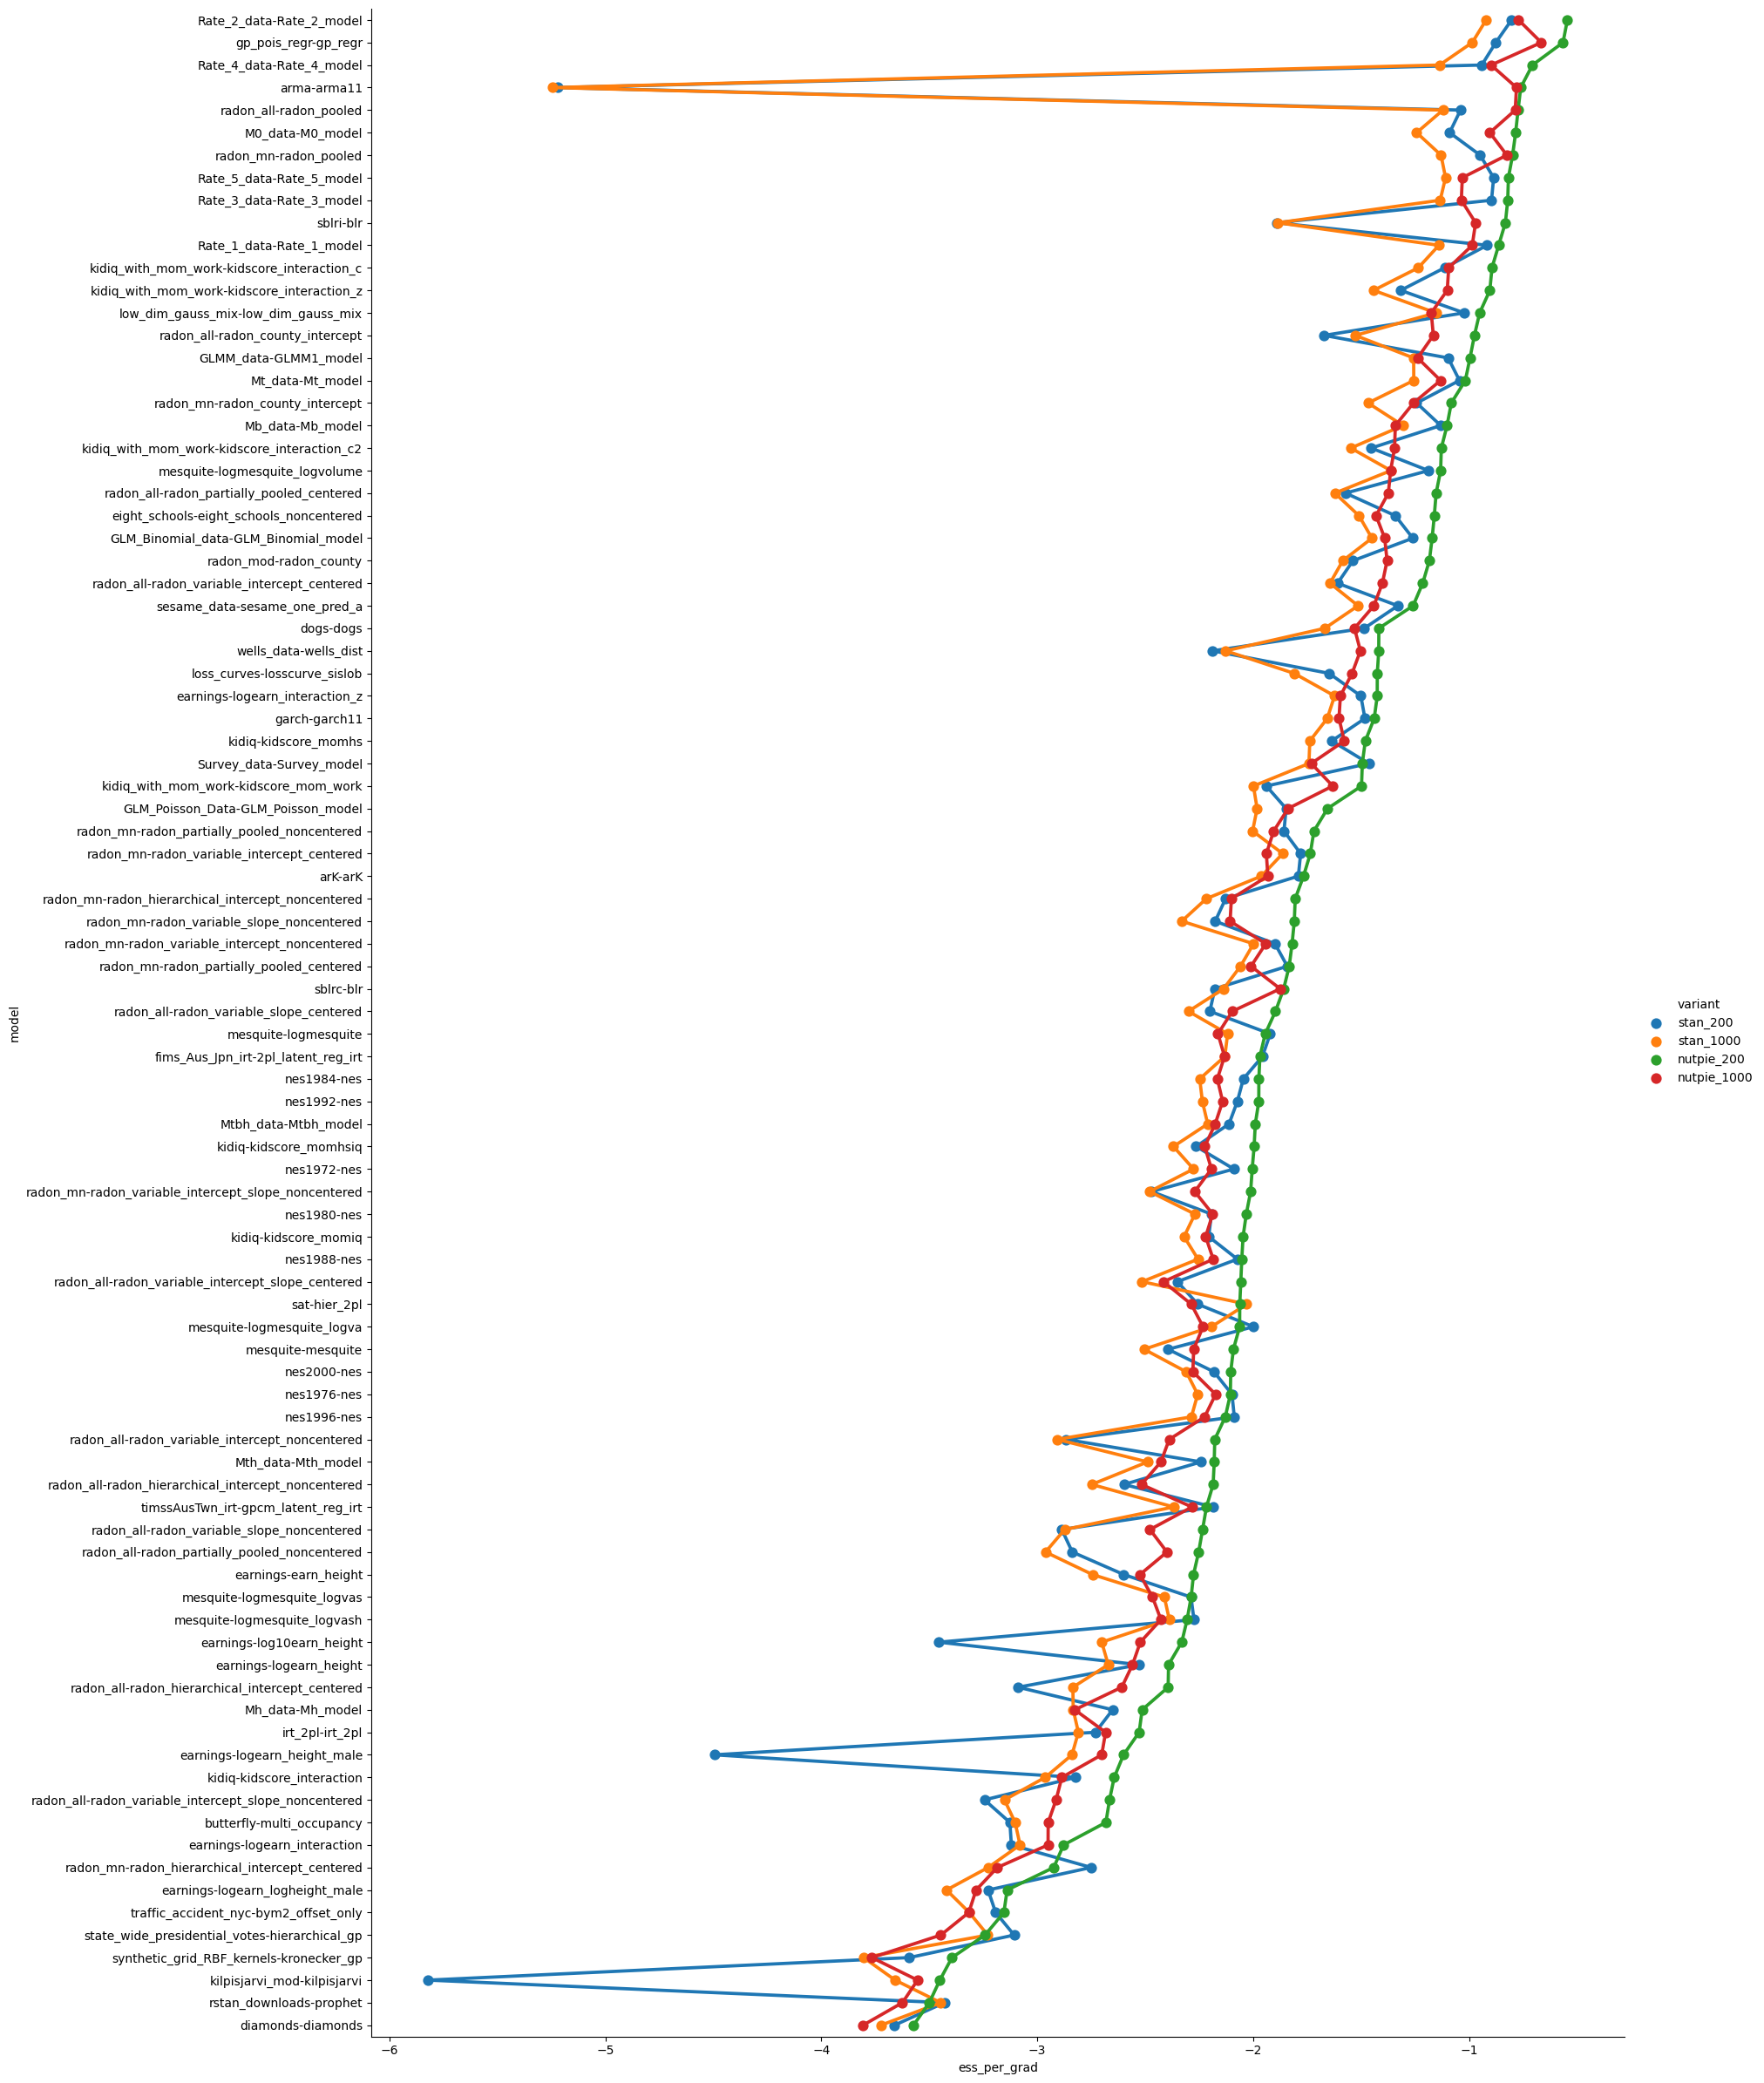

In [19]:
x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"])
x = ds.ess_per_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
sort = x.sel(variant="nutpie_200")
sns.catplot(
    #ds.ess_per_posterior_grad.to_dataframe().reset_index(),
    np.log10(x).sortby(sort, False).to_dataframe().reset_index(),
    x="ess_per_grad",
    y="model",
    hue="variant",
    #col="sampler",
    orient="h",
    kind="point",
    height=24,
    aspect=0.8,
)

/home/adr/mambaforge/envs/pymc-dev/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'variant' would corrupt indices for other variables: ['sampler', 'num_tune']. This will raise an error in the future. Use `.drop_vars({'variant', 'sampler', 'num_tune'})` before assigning new coordinate values.
  data.coords.update(results)


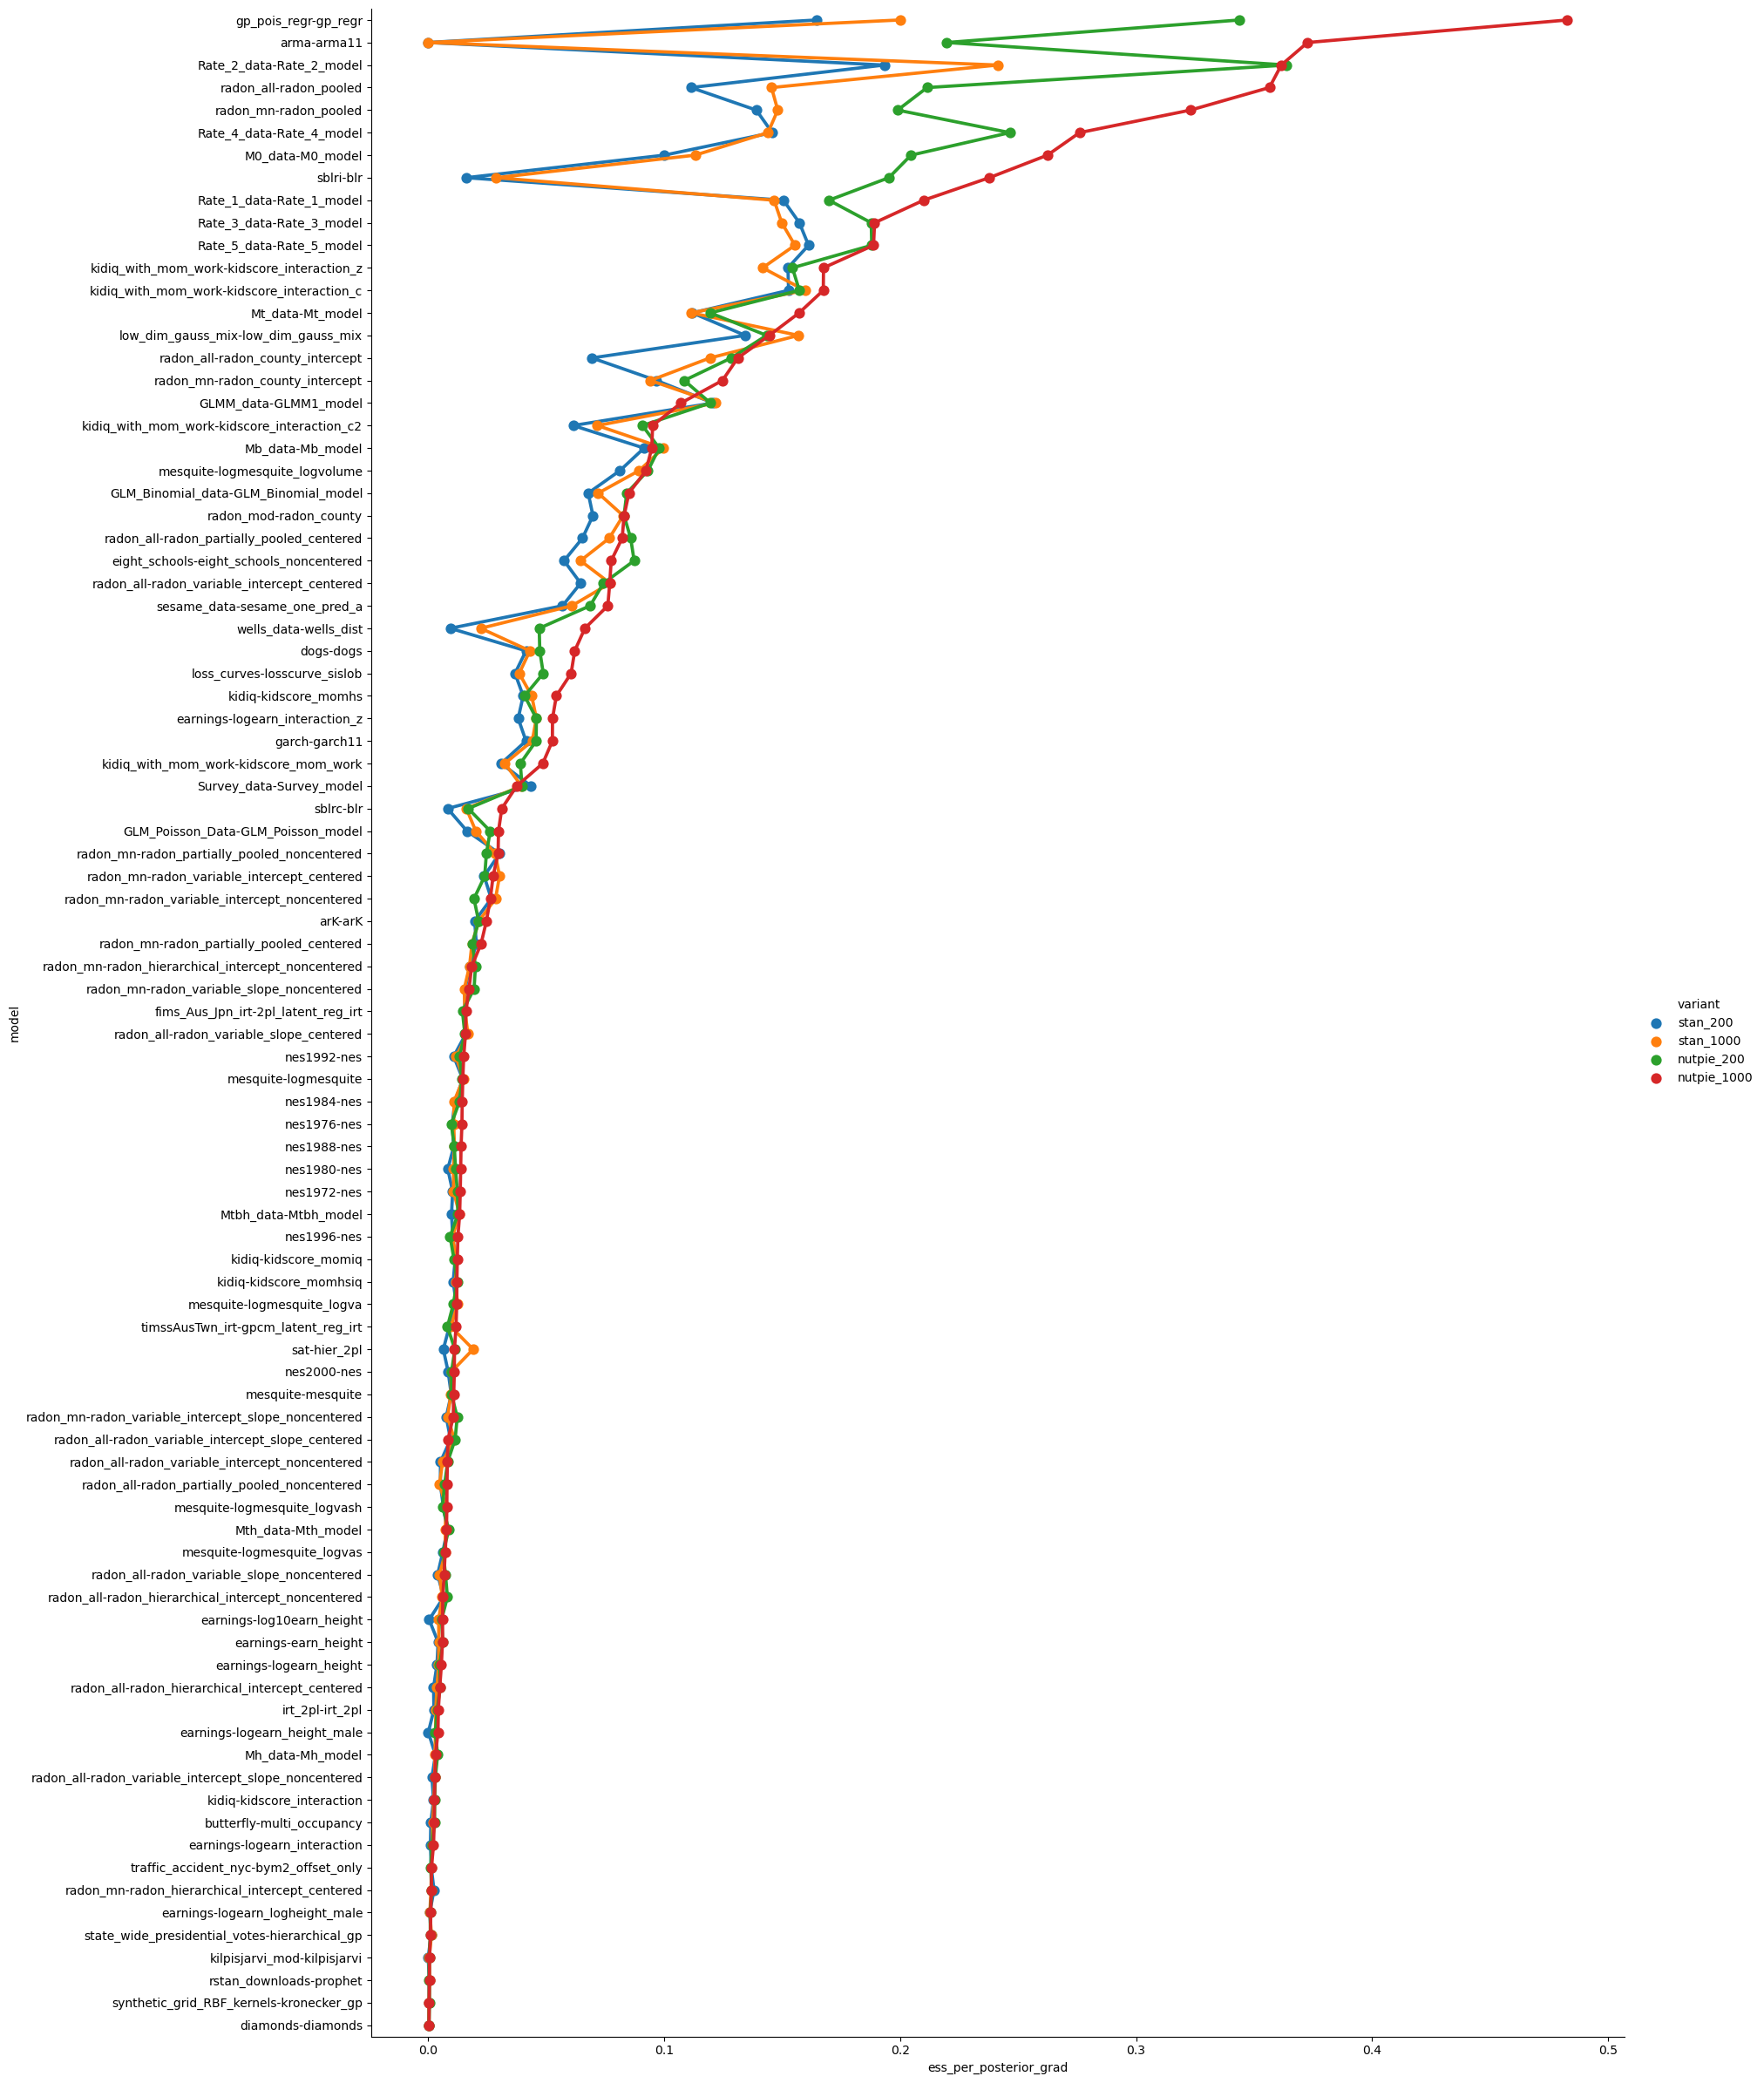

In [117]:
x = ds.ess_per_posterior_grad.stack(variant=["sampler", "num_tune"]).assign_coords(variant=lambda x: [f"{a}_{b}" for a, b in zip(x.sampler.values, x.num_tune.values)])
sort = x.sel(variant="nutpie_1000")
sns.catplot(
    #ds.ess_per_posterior_grad.to_dataframe().reset_index(),
    x.sortby(sort, False).to_dataframe().reset_index(),
    x="ess_per_posterior_grad",
    y="model",
    hue="variant",
    #col="sampler",
    orient="h",
    kind="point",
    height=24,
    aspect=0.8,
)

/home/adr/mambaforge/envs/pymc-dev/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


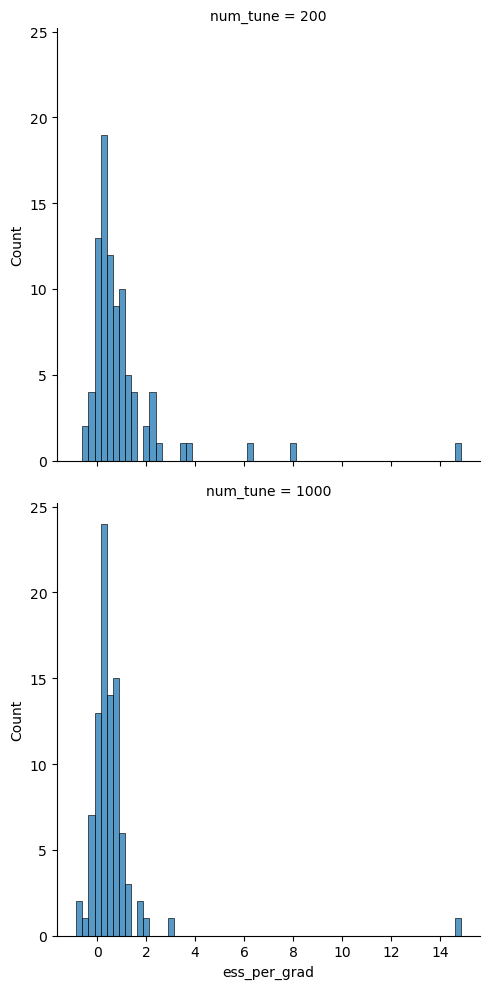

In [135]:
sns.displot(np.log2((ds.sel(sampler="nutpie") / ds.sel(sampler="stan"))).ess_per_grad.to_dataframe().reset_index(), x="ess_per_grad", row="num_tune")

In [7]:
#good = ((divs_stan < 10) | (divs_nutpie < 10)) & ((ess_mins_nutpie > 200) | (ess_mins_stan > 200))
good_stan = (divs_stan < 5) & (ess_mins_stan > 500)
good_nutpie = (divs_nutpie < 5) & (ess_mins_nutpie > 500)
good = good_stan | good_nutpie

NameError: name 'divs_stan' is not defined

In [ ]:
summaries[0]